In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Load data files
import numpy as np
import urllib.request
import io


In [2]:
import torch

In [7]:
from timeit import default_timer as timer
import sklearn.datasets

In [233]:
n_classes = 2

X, y = sklearn.datasets.make_classification(n_samples=1000,
                                            n_features=10000,
                                            n_informative=5,
                                            n_redundant=0,
                                            n_repeated=0,
                                            class_sep=0.5,
                                            n_classes=n_classes,
                                            random_state = 4)

n_features = X.shape[1]

In [234]:
# transform labels
y = np.where(y == 0, -1, y)

In [418]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Load data files
import numpy as np
import urllib.request
import io

url_x = 'https://github.com/jnear/cs211-data-privacy/raw/master/slides/adult_processed_x.npy'
url_y = 'https://github.com/jnear/cs211-data-privacy/raw/master/slides/adult_processed_y.npy'

with urllib.request.urlopen(url_x) as url:
    f = io.BytesIO(url.read())
X = np.load(f)

with urllib.request.urlopen(url_y) as url:
    f = io.BytesIO(url.read())
y = np.load(f)

In [419]:
def gaussian_mech_zCDP_vec(vec, sensitivity, rho):
    sigma = np.sqrt((sensitivity**2) / (2 * rho))
    return vec + np.random.normal(loc=0, scale=sigma, size=vec.shape)

In [420]:
# Split data into training and test sets
training_size = int(X.shape[0] * 0.8)

X_train = X[:training_size]
X_test = X[training_size:]

y_train = y[:training_size]
y_test = y[training_size:]

print('Train and test set sizes:', len(y_train), len(y_test))

Train and test set sizes: 36176 9044


# Clipping and Gradient definition

In [421]:
def L2_clip_array(vs , b):
    norms = np.linalg.norm(vs, ord = 2, axis = 1)
    ratios = vs/norms[:, None]
    results = np.where((norms > b)[:, None], b*ratios, vs)
    return results

In [422]:
def vgradient(theta_in, x_in, y_in, C):
    x = x_in
    y = y_in
    theta = theta_in
    exponent = y * np.dot(x, theta)
    rhs = (y/(1+np.exp(exponent)))
    gradients = -(x*rhs[:, None])
    return gradients
#     clipped_grads = L2_clip_array(gradients, C)
#     return np.sum(clipped_grads, axis = 0)

In [423]:
# Prediction: take a model (theta) and a single example (xi) and return its predicted label
def predict(xi, theta, bias=0):
    label = np.sign(xi @ theta + bias)
    return label

def accuracy(theta):
    return np.sum(predict(X_test, theta) == y_test)/X_test.shape[0]

# Baseline (gradient clipping DP-SGD)

In [529]:
def dp_gradient_descent(epochs, rho):
    rho_i = rho/epochs
    theta = np.zeros(X_train.shape[1])  # leaks the number of features, without privacy
    clipping_param = 1
    num_examples = X_train.shape[0]     # leaks the number of training examples, without privacy

    BATCH_SIZE = 256
    num_batches = int(num_examples / BATCH_SIZE)
    batches_X = np.array_split(X, num_batches)
    batches_y = np.array_split(y, num_batches)

    for i in range(epochs):

        for xs, ys in zip(batches_X, batches_y):
            grads           = vgradient(theta, xs, ys, clipping_param)
            clipped_grads   = L2_clip_array(grads, clipping_param)
            avg_grad        = np.mean(clipped_grads, axis=0)
            noisy_grad      = gaussian_mech_zCDP_vec(avg_grad, clipping_param/len(xs), rho_i)
            theta           = theta - noisy_grad

    return theta

In [531]:
rho = .001
epochs = 5
print('eps:', zcdp_eps(rho, 1e-5))
accs = [accuracy(dp_gradient_descent(epochs, rho)) for _ in range(5)]
print('mean:', np.mean(accs))
print('std:', np.std(accs))

eps: 0.21559660262893474
mean: 0.7682883679787704
std: 0.01246392448941368


# SignSGD + dimensionality reduction

In [428]:
# exponential mechanism, k times
# sat rho-zCDP
def top_k(grads, C, k, rho):
    rho_i = rho / k
    clipped_grads = np.clip(grads, -C, C)
    avg_grad = np.mean(clipped_grads, axis=0)
    sens = C / len(grads)
    noise = np.random.gumbel(loc=0, scale=sens/np.sqrt(8*rho_i), size=len(avg_grad))
    noisy_scores = avg_grad + noise
    k_ind = np.argpartition(noisy_scores, -k)[-k:]
    return k_ind

In [429]:
def dp_gradient_descent(epochs, rho, k=20, clipping_param=.3):
    rho_i = rho/epochs
    d = X_train.shape[1]
    theta = np.zeros(d)                 # leaks the number of features, without privacy
    num_examples = X_train.shape[0]     # leaks the number of training examples, without privacy

    BATCH_SIZE = 256
    num_batches = int(num_examples / BATCH_SIZE)
    batches_X = np.array_split(X, num_batches)
    batches_y = np.array_split(y, num_batches)

    for i in range(epochs):

        for xs, ys in zip(batches_X, batches_y):
            grads           = vgradient(theta, xs, ys, clipping_param)
            
            # this is not private yet
            k_ind_old       = np.argpartition(np.abs(np.mean(grads, axis=0)), -k)[-k:]
            k_ind           = top_k(grads, clipping_param, k, .1*rho_i)
            k_grads         = grads[:, k_ind]
            #print('old k_ind:', k_ind_old, 'new k_ind:', k_ind)
            
            # clip just the chosen parameters
            clipped_grads   = L2_clip_array(k_grads, clipping_param)
            avg_grad        = np.mean(clipped_grads, axis=0) # sensitivity is clipping_param / len(xs)
            noisy_grad      = gaussian_mech_zCDP_vec(avg_grad, clipping_param/len(xs), .9*rho_i)
            full_grad       = np.zeros(d)
            full_grad[k_ind]= noisy_grad
            #print(full_grad)
            theta           = theta - full_grad       # regular version
            #theta            = theta - (.5/(i+5))*np.sign(full_grad)     # sign version

    return theta

In [560]:
def dp_gradient_descent(epochs, rho, k=20, clipping_param=.3):
    rho_i = rho/epochs
    d = X_train.shape[1]
    theta = np.zeros(d)                 # leaks the number of features, without privacy
    num_examples = X_train.shape[0]     # leaks the number of training examples, without privacy

    BATCH_SIZE = 256
    num_batches = int(num_examples / BATCH_SIZE)
    batches_X = np.array_split(X, num_batches)
    batches_y = np.array_split(y, num_batches)

    for i in range(epochs):
        eta = (.5/(i+10))
        #print('rate:', eta)

        for xs, ys in zip(batches_X, batches_y):
            grads           = vgradient(theta, xs, ys, clipping_param)
            k_ind_pos       = top_k(grads, clipping_param, k, .5*rho_i)
            k_ind_neg       = top_k(-grads, clipping_param, k, .5*rho_i)
            full_grad       = np.zeros(d)
            
#             print('num rate', .01*rate)
#             print('analytic rate', (.5 / (i+5)))

            full_grad[k_ind_pos] = 1
            full_grad[k_ind_neg] = -1

            theta            = theta - eta*full_grad     # sign version
            #theta            = theta - *rate*full_grad     # sign version
    return theta

In [561]:
def zcdp_eps(rho, delta):
    return rho + 2*np.sqrt(rho * np.log(1/delta))
zcdp_eps(0.001, 1e-5)

0.21559660262893474

In [562]:
rho = .001
epochs = 5
print('eps:', zcdp_eps(rho, 1e-5))
accs = [accuracy(dp_gradient_descent(epochs, rho, k=10, clipping_param=.1)) for _ in range(5)]
print('mean:', np.mean(accs))
print('std:', np.std(accs))

eps: 0.21559660262893474
mean: 0.7672711189739054
std: 0.010352001473144462


In [503]:
rho = .1
epochs = 5
print('eps:', zcdp_eps(rho, 1e-5))
accs = [accuracy(dp_gradient_descent(epochs, rho, k=50, clipping_param=.1)) for _ in range(5)]
print('mean:', np.mean(accs))
print('std:', np.std(accs))

eps: 2.2459660262893473
rate: 0.08
rate: 0.07272727272727274
rate: 0.06666666666666667
rate: 0.06153846153846154
rate: 0.05714285714285715
rate: 0.08
rate: 0.07272727272727274
rate: 0.06666666666666667
rate: 0.06153846153846154
rate: 0.05714285714285715
rate: 0.08
rate: 0.07272727272727274
rate: 0.06666666666666667
rate: 0.06153846153846154
rate: 0.05714285714285715
rate: 0.08
rate: 0.07272727272727274
rate: 0.06666666666666667
rate: 0.06153846153846154
rate: 0.05714285714285715
rate: 0.08
rate: 0.07272727272727274
rate: 0.06666666666666667
rate: 0.06153846153846154
rate: 0.05714285714285715
mean: 0.6990269792127377
std: 0.004569119528636874


In [ ]:
ks = [1, 10, 20, 50, 70, 100]
ks = np.linspace(10, 80, 40)
runs = 20
means = []
stds = []
for k in ks:
    print(k)
    accs = [accuracy(dp_gradient_descent(epochs, rho)) for _ in range(runs)]
    means.append(np.mean(accs))
    stds.append(np.std(accs))

<ErrorbarContainer object of 3 artists>

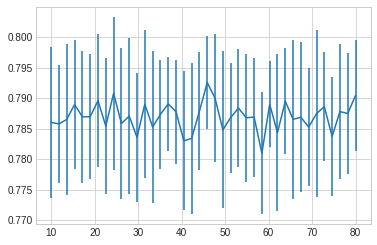

In [211]:
plt.errorbar(ks, means, yerr=stds)